In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, log_loss, precision_recall_curve
import xgboost as xgb
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.base import BaseEstimator, ClassifierMixin
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings('ignore')

/home/neuralist/DS&ML/Data_Science/MIPT_Data_Scientist/DA & ML/UFC-predictor/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [87]:
data = pd.read_csv('data_preprocessed/data_new_3511.csv', index_col='Unnamed: 0') #drop(columns=['RedFighter', 'BlueFighter', 'Result'], axis=1)
# y = pd.read_csv('ufc-master-for-binary-classification.csv', index_col='Unnamed: 0')['Result']

In [88]:
# data = data.loc[:2000, :]
X = data.drop(['Result'], axis=1)
y = data['Result']

In [89]:
# X = X.iloc[:1500, :]
# y = y.iloc[:1500]


test_size = int(len(X)*0.25)

X_train = X.iloc[test_size:, :]
y_train = y.iloc[test_size:]
X_test = X.iloc[:test_size, :]
y_test = y.iloc[:test_size]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, stratify=y)

In [90]:
# Масштабируйте данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBoost

In [96]:
def objective(trial):
    # Определение гиперпараметров для оптимизации
    max_depth = trial.suggest_int('max_depth', 1, 16)
    learning_rate = trial.suggest_loguniform('learning_rate', 0.01, 1.0)
    n_estimators = trial.suggest_int('n_estimators', 2, 100)
    gamma = trial.suggest_loguniform('gamma', 0.01, 10.0)
    subsample = trial.suggest_uniform('subsample', 0.5, 1.0)
    colsample_bytree = trial.suggest_uniform('colsample_bytree', 0.2, 1.0)
    reg_alpha = trial.suggest_loguniform('reg_alpha', 0.01, 10.0)
    reg_lambda = trial.suggest_loguniform('reg_lambda', 0.01, 10.0)

    # Создание модели
    model = xgb.XGBClassifier(max_depth=max_depth, learning_rate=learning_rate,
                              n_estimators=n_estimators, gamma=gamma,
                              subsample=subsample, colsample_bytree=colsample_bytree,
                              reg_alpha=reg_alpha, reg_lambda=reg_lambda)

    # Обучение модели
    model.fit(X_train_scaled, y_train)

    # Оценка модели
    y_pred = model.predict(X_test_scaled)
    f1 = f1_score(y_test, y_pred)

    return f1

# Создание Bayesian Optimization
study = optuna.create_study(direction='maximize')

# Запуск Bayesian Optimization
study.optimize(objective, n_trials=200)

# Вывод лучших гиперпараметров и результата
# print("Лучшие гиперпараметры:", study.best_params)
# print("Результат:", study.best_value)

# Создание модели с лучшими гиперпараметрами
best_model = xgb.XGBClassifier(**study.best_params)
best_model.fit(X_train_scaled, y_train)

# Оценка модели с лучшими гиперпараметрами
y_pred = best_model.predict(X_test_scaled)
print("F1-мера модели с лучшими гиперпараметрами:", f1_score(y_test, y_pred, average='weighted'))
# Вывод параметров лучшей модели
print("Параметры лучшей модели:", best_model.get_params())

[I 2025-01-19 15:58:37,696] A new study created in memory with name: no-name-d7e06111-ab3c-4df3-a8f2-bfe91b66b0f4
[I 2025-01-19 15:58:37,828] Trial 0 finished with value: 0.33530571992110453 and parameters: {'max_depth': 11, 'learning_rate': 0.017051143581133153, 'n_estimators': 99, 'gamma': 6.366676173434675, 'subsample': 0.6139715496158887, 'colsample_bytree': 0.4638511266278858, 'reg_alpha': 0.04103389475365022, 'reg_lambda': 0.1456756405340261}. Best is trial 0 with value: 0.33530571992110453.
[I 2025-01-19 15:58:37,881] Trial 1 finished with value: 0.4 and parameters: {'max_depth': 11, 'learning_rate': 0.06602363705104963, 'n_estimators': 88, 'gamma': 5.126011320351311, 'subsample': 0.6455504863592917, 'colsample_bytree': 0.5970204473773577, 'reg_alpha': 5.983955900500012, 'reg_lambda': 1.0569014100766763}. Best is trial 1 with value: 0.4.
[I 2025-01-19 15:58:38,163] Trial 2 finished with value: 0.5267605633802817 and parameters: {'max_depth': 15, 'learning_rate': 0.15486364997621

F1-мера модели с лучшими гиперпараметрами: 0.6479896847347691
Параметры лучшей модели: {'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.40341165415130364, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.0535585330106771, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.384102425275553, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 10, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 52, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': 3.368590924254374, 'reg_lambda': 6.423007081688496, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.6349862238373374, 'tre

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       496
           1       0.61      0.56      0.58       381

    accuracy                           0.65       877
   macro avg       0.64      0.64      0.64       877
weighted avg       0.65      0.65      0.65       877



Text(0.5, 23.52222222222222, 'predicted value')

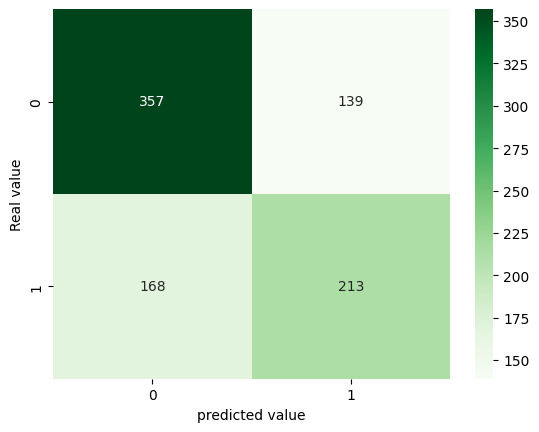

In [97]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [93]:
# Определение целевой функции для оптимизации
def objective(trial):
    # Определение гиперпараметров для перебора
    params = {
            'max_depth': trial.suggest_int('max_depth', 5, 40),
            'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
            'n_estimators': trial.suggest_int('n_estimators', 50, 250),
            'gamma': trial.suggest_loguniform('gamma', 0.01, 10),
            'subsample': trial.suggest_uniform('subsample', 0.5, 1),
            'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 10),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 10),
            'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 100)
    }

    # Обучение модели
    xgb_model = xgb.XGBClassifier(objective='binary:logistic', **params)
    xgb_model.fit(X_train_scaled, y_train)

    # Предсказание на тестовой выборке
    y_pred = xgb_model.predict(X_test_scaled)
    # y_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

    # Расчет метрики PR-AUC
    # precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
    # pr_auc = auc(recall_pr, precision_pr)
    f1 = f1_score(y_test, y_pred)

    return f1

# Перебор гиперпараметров
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=60)

# Обучение лучшей модели
best_params = study.best_params
best_model = xgb.XGBClassifier(objective='binary:logistic', **best_params)
best_model.fit(X_train_scaled, y_train)

# Предсказание на тестовой выборке
y_pred = best_model.predict(X_test_scaled)
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]

# Расчет метрик
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall_pr, precision_pr)

# Вывод метрик
print('Лучшие гиперпараметры:', best_params)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1: {f1:.4f}')
print(f'ROC-AUC: {roc_auc:.4f}')
print(f'PR-AUC: {pr_auc:.4f}')

[I 2025-01-19 15:56:56,186] A new study created in memory with name: no-name-d19f5e54-fab3-4e85-b22e-4da72d4e7586
[I 2025-01-19 15:56:56,490] Trial 0 finished with value: 0.598 and parameters: {'max_depth': 5, 'learning_rate': 0.4447841927545415, 'n_estimators': 250, 'gamma': 5.003244484031145, 'subsample': 0.5653822820548708, 'colsample_bytree': 0.6145112467241082, 'reg_alpha': 4.59379556164608, 'reg_lambda': 0.7423134360590833, 'scale_pos_weight': 21}. Best is trial 0 with value: 0.598.
[I 2025-01-19 15:56:56,770] Trial 1 finished with value: 0.6081754735792622 and parameters: {'max_depth': 28, 'learning_rate': 0.3110806877310829, 'n_estimators': 108, 'gamma': 6.921327931833406, 'subsample': 0.5681826630852849, 'colsample_bytree': 0.8291345335005218, 'reg_alpha': 0.015159232935483036, 'reg_lambda': 0.27278157099873457, 'scale_pos_weight': 14}. Best is trial 1 with value: 0.6081754735792622.
[I 2025-01-19 15:56:57,588] Trial 2 finished with value: 0.6385068762278978 and parameters: {'

Лучшие гиперпараметры: {'max_depth': 35, 'learning_rate': 0.018468453828706613, 'n_estimators': 249, 'gamma': 0.5253026014778678, 'subsample': 0.7749075961074907, 'colsample_bytree': 0.7197125194803997, 'reg_alpha': 0.02896871343404464, 'reg_lambda': 0.40010698847192155, 'scale_pos_weight': 63}
Precision: 0.5000
Recall: 0.9239
F1: 0.6488
ROC-AUC: 0.6769
PR-AUC: 0.5817


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.24      0.38       496
           1       0.49      0.95      0.65       381

    accuracy                           0.55       877
   macro avg       0.67      0.59      0.51       877
weighted avg       0.70      0.55      0.49       877



Text(0.5, 23.52222222222222, 'predicted value')

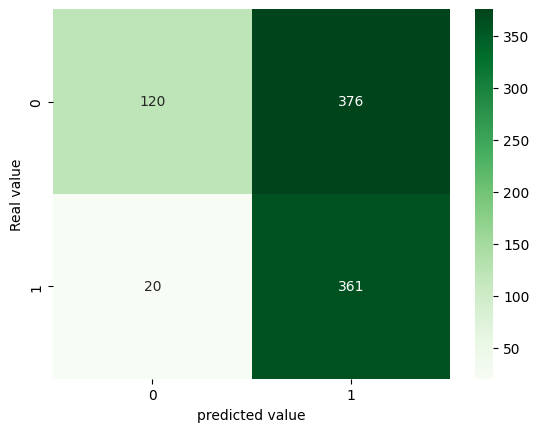

In [73]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

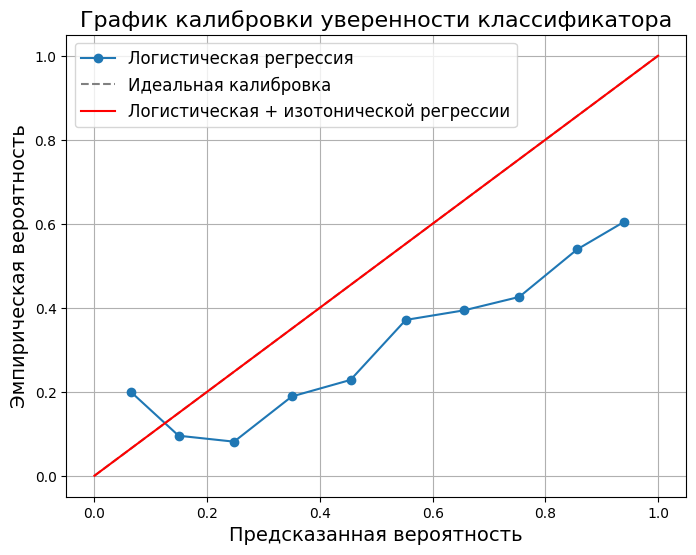

In [98]:
from sklearn.calibration import calibration_curve, FrozenEstimator, CalibratedClassifierCV


# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10, strategy="uniform")

# Построение графика
plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker='o', label='Логистическая регрессия')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Идеальная калибровка')

# Каоибровка вероятностей
calibrated_model_iso = CalibratedClassifierCV(FrozenEstimator(best_model), method='isotonic', cv='prefit')
calibrated_model_iso.fit(X_test_scaled, y_test)

# Предсказанные вероятности после калибровки
calibrated_probs_iso = calibrated_model_iso.predict_proba(X_test_scaled)[:, 1]
prob_true, prob_pred = calibration_curve(y_test, calibrated_probs_iso, n_bins=10, strategy="uniform")
plt.plot(prob_pred, prob_true, color='red', label='Логистическая + изотонической регрессии')
plt.xlabel('Предсказанная вероятность', fontsize=14)
plt.ylabel('Эмпирическая вероятность', fontsize=14)
plt.title('График калибровки уверенности классификатора', fontsize=16)
plt.legend(fontsize=12)
plt.grid()

In [99]:
y_pred = calibrated_model_iso.predict(X_test_scaled)

precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
pr_auc = auc(recall_pr, precision_pr)

log_reg_recall = recall_score(y_test, y_pred, average='weighted')
log_reg_precision = precision_score(y_test, y_pred, average='weighted')
log_reg_f1 = f1_score(y_test, y_pred, average='weighted')
log_reg_accuracy = accuracy_score(y_test, y_pred)
log_reg_roc_auc = roc_auc_score(y_test, calibrated_probs_iso, average='weighted')

log_reg_metrics = [(np.round(log_reg_recall, 3),
                    np.round(log_reg_precision, 3),
                    np.round(log_reg_f1, 3),
                    np.round(log_reg_accuracy, 3),
                    np.round(log_reg_roc_auc, 3),
                    np.round(pr_auc, 3))]

metrics = pd.DataFrame(data = log_reg_metrics, columns=['Recall','Precision','F1 Score', 'Accuracy', 'ROC-AUC', 'PR-AUC'])
metrics.insert(0, 'Model', 'LogReg+Isotonic Regression')
metrics

,Model,Recall,Precision,F1 Score,Accuracy,ROC-AUC,PR-AUC
0,LogReg+Isotonic Regression,0.651,0.649,0.649,0.651,0.688,0.646


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70       496
           1       0.61      0.56      0.58       381

    accuracy                           0.65       877
   macro avg       0.64      0.64      0.64       877
weighted avg       0.65      0.65      0.65       877



Text(0.5, 23.52222222222222, 'predicted value')

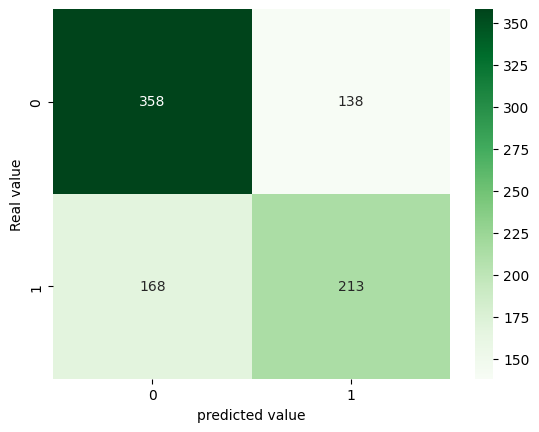

In [100]:
# Выводим метрики качества модели
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Матрица ошибок

sns.heatmap(confusion_matrix(y_test, y_pred),  annot=True, fmt="d", cmap='Greens')
plt.ylabel('Real value')
plt.xlabel('predicted value')

In [81]:
fighters = pd.read_csv('data_preprocessed/data_new_3511_with_names.csv', index_col='Unnamed: 0')

In [82]:
y_proba = calibrated_model_iso.predict_proba(X_test_scaled)

# Создание датафрейма для хранения результатов
results_df = pd.DataFrame({
    'RedFighter': fighters['RedFighter'].iloc[:test_size],
    'BlueFighter': fighters['BlueFighter'].iloc[:test_size],
    'ProbabilityRedWins': y_proba [:, 0],
    'ProbabilityBlueWins': y_proba [:, 1],
    'ActualWinner': fighters['Result'].iloc[:test_size]
})

results_df['Predicted_Winner'] = (results_df['ProbabilityBlueWins'] > results_df['ProbabilityRedWins']).astype(int)
results_df['Prediction_Errors'] = np.abs(results_df['Predicted_Winner'] - results_df['ActualWinner'])
results_df.iloc[:30, :]

,RedFighter,BlueFighter,ProbabilityRedWins,ProbabilityBlueWins,ActualWinner,Predicted_Winner,Prediction_Errors
1,Shavkat Rakhmonov,Ian Machado Garry,0.524194,0.475806,0,0,0
2,Ciryl Gane,Alexander Volkov,0.524194,0.475806,0,0,0
3,Bryce Mitchell,Kron Gracie,1.000000,0.000000,0,0,0
4,Nate Landwehr,Dooho Choi,0.524194,0.475806,1,0,1
5,Dominick Reyes,Anthony Smith,0.683333,0.316667,0,0,0
6,Vicente Luque,Themba Gorimbo,0.288889,0.711111,0,1,1
7,Movsar Evloev,Aljamain Sterling,0.857143,0.142857,0,0,0
8,Randy Brown,Bryan Battle,0.524194,0.475806,1,0,1
9,Chris Weidman,Eryk Anders,0.683333,0.316667,1,0,1
10,Cody Durden,Joshua Van,0.666667,0.333333,1,0,1


In [59]:
# Инициализация пустого DataFrame
metrics = pd.DataFrame(columns=['Threshold', 'Recall', 'Precision', 'F1 Score'])

# fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(16,16))
thresholds = np.arange(0.1, 1, 0.1)

for i in range(9):

    predictions = (calibrated_probs_iso  >= thresholds[i]).astype(int)
    precision_pr, recall_pr, _ = precision_recall_curve(y_test, calibrated_probs_iso )
    pr_auc = auc(recall_pr, precision_pr)
    log_reg_recall = recall_score(y_test, predictions)
    log_reg_precision = precision_score(y_test, predictions)
    log_reg_f1 = f1_score(y_test, predictions)
    log_reg_accuracy = accuracy_score(y_test, predictions)
    log_reg_roc_auc = roc_auc_score(y_test, predictions)

   # Создание новой строки в виде DataFrame
    new_row = pd.DataFrame(data=[[thresholds[i],
                                np.round(log_reg_recall, 3),
                                np.round(log_reg_precision, 3),
                                np.round(log_reg_f1, 3)]],                              

                            columns=['Threshold', 'Recall', 'Precision', 'F1 Score']
                            )

    # Добавление строки с помощью pd.concat
    metrics = pd.concat([metrics, new_row], ignore_index=True)
metrics

,Threshold,Recall,Precision,F1 Score
0,0.1,1.000,0.508,0.673
1,0.2,0.994,0.517,0.680
2,0.3,0.892,0.587,0.708
3,0.4,0.874,0.593,0.707
4,0.5,0.635,0.662,0.648
5,0.6,0.545,0.695,0.611
6,0.7,0.287,0.727,0.412
7,0.8,0.006,1.000,0.012
8,0.9,0.006,1.000,0.012


### PyTorch

In [83]:
y_train =np.array(y_train)
y_test =np.array(y_test)

In [84]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train_scaled)
# X_test_scaled = scaler.transform(X_test_scaled)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out
    
# Параметры модели
input_size = X_train_scaled.shape[1]
hidden_size = 64
num_classes = 2
learning_rate = 0.01
num_epochs = 25
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [85]:
# Обучение модели
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [5/25], Loss: 0.7301
Epoch [10/25], Loss: 0.4720
Epoch [15/25], Loss: 0.3680
Epoch [20/25], Loss: 0.3119
Epoch [25/25], Loss: 0.6169


In [86]:
# Оценка модели
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)

    # Расчет метрик
    precision = precision_score(y_test_tensor, predicted)
    recall = recall_score(y_test_tensor, predicted)
    f1 = f1_score(y_test_tensor, predicted)
    roc_auc = roc_auc_score(y_test_tensor, predicted)
    precision_pr, recall_pr, _ = precision_recall_curve(y_test_tensor, predicted)
    pr_auc = auc(recall_pr, precision_pr)

    # Вывод метрик
    print('Лучшие гиперпараметры:', best_params)
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1: {f1:.4f}')
    print(f'ROC-AUC: {roc_auc:.4f}')
    print(f'PR-AUC: {pr_auc:.4f}')
    # accuracy = correct / total
    # print(f'Accuracy: {accuracy:.4f}')

    # # Вычисление F1-меры
    # f1 = f1_score(y_test_tensor, predicted, average='weighted')
    # print(f'F1 Score: {f1:.4f}')

Лучшие гиперпараметры: {'max_depth': 26, 'learning_rate': 0.06733750895159063, 'n_estimators': 72, 'gamma': 0.02754006368071007, 'subsample': 0.7106856172443738, 'colsample_bytree': 0.8371456397040624, 'reg_alpha': 1.9920726047781117, 'reg_lambda': 0.377982472949744, 'scale_pos_weight': 47}
Precision: 0.5943
Recall: 0.3307
F1: 0.4250
ROC-AUC: 0.5787
PR-AUC: 0.6079


### Аугментация данных

In [64]:
# Функция для аугментации данных
def augment_data(X, y, noise_level=0.05):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise
    y_augmented = y.copy()
    return X_augmented, y_augmented

# Аугментация тренировочных данных
X_train_augmented, y_train_augmented = augment_data(X_train, y_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented.values, dtype=torch.float32)
# y_train_augmented_tensor = torch.tensor(y_train_augmented.values, dtype=torch.long)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/25], Loss: 0.6018
Epoch [20/25], Loss: 0.7282


In [65]:
# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after augmentation: {accuracy:.4f}')

    # Вычисление F1-меры
    from sklearn.metrics import f1_score
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after augmentation: {f1:.4f}')

Accuracy after augmentation: 0.5734
F1 Score after augmentation: 0.4965


### Датасет + аугментированный датасет

In [22]:
# # Стандартизация данных
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Определение нейросети
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

# Параметры модели
input_size = X_train.shape[1]
hidden_size = 128
num_classes = 2
learning_rate = 0.01
num_epochs = 50
batch_size = 32

# Преобразование данных в тензоры
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Создание DataLoader для базовых данных
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Функция для аугментации данных
def augment_data(X,noise_level=0.04):
    noise = np.random.normal(0, noise_level, X.shape)
    X_augmented = X + noise  
    return X_augmented

# Аугментация тренировочных данных
X_train_augmented = augment_data(X_train)

# Преобразование аугментированных данных в тензоры
X_train_augmented_tensor = torch.tensor(X_train_augmented.values, dtype=torch.float32)

# Создание DataLoader для аугментированных данных
train_dataset_augmented = TensorDataset(X_train_augmented_tensor, y_train_tensor)
train_loader_augmented = DataLoader(dataset=train_dataset_augmented, batch_size=batch_size, shuffle=True)

# Инициализация модели, функции потерь и оптимизатора
model = NeuralNet(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Обучение модели на базовых данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на базовых данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on base data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on base data: {f1:.4f}')

# Обучение модели на аугментированных данных
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_augmented):
        # Прямой проход
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Обратный проход и оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Оценка модели после обучения на аугментированных данных
model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total
    print(f'Accuracy after training on augmented data: {accuracy:.4f}')

    # Вычисление F1-меры
    f1 = f1_score(y_test_tensor, predicted, average='weighted')
    print(f'F1 Score after training on augmented data: {f1:.4f}')

Epoch [10/50], Loss: 0.6732
Epoch [20/50], Loss: 0.6395
Epoch [30/50], Loss: 0.6357
Epoch [40/50], Loss: 0.6990
Epoch [50/50], Loss: 0.6733
Accuracy after training on base data: 0.5613
F1 Score after training on base data: 0.4046
Epoch [10/50], Loss: 0.6282
Epoch [20/50], Loss: 0.6387
Epoch [30/50], Loss: 0.7259
Epoch [40/50], Loss: 0.7138
Epoch [50/50], Loss: 0.7347
Accuracy after training on augmented data: 0.5613
F1 Score after training on augmented data: 0.4046
